In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta

sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [2]:
def concat_subsets(files):
    df = []
    for f in files:
        manyfr = pd.read_csv(f)

        manyfr = gpd.GeoDataFrame(manyfr)

        manyfr.t = manyfr.t.astype("datetime64[ns]")
        df.append(manyfr)
    df = pd.concat(df)
    return(df)

def get_lt(lt_string = "Lt_CA_Boreal_"):
    files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/" + lt_string +"*.csv")
    return(concat_subsets(files))

In [3]:
lt = get_lt() # ~ 2.9 GB

In [4]:
prov = fv.ca_prov()

In [5]:
lt.columns

Index(['Unnamed: 0', 'InterCloud', 't', 'lat', 'lon', 'current_mag',
       'multiplicity_0', 'accr', 'error_elps', 'num_station', 'geometry'],
      dtype='object')

In [6]:
# lt = lt.sjoin(prov) # Too computationally expensive??
# lt

lt = gpd.GeoDataFrame(lt, geometry = gpd.points_from_xy(lt['lon'], lt['lat']), crs = "EPSG:4326")

In [7]:
#prov.crs

lt = lt.sjoin(prov) # Too computationally expensive??
lt

,Unnamed: 0,InterCloud,t,lat,lon,current_mag,multiplicity_0,accr,error_elps,num_station,geometry,index_right,prov_name_fr,prov_name_en
237,3778431,0,2023-09-29 17:31:51.050,48.131877,-90.376448,-4619.0,0,0.0,18.0,2.0,POINT (-90.37645 48.13188),9,Ontario,Ontario
238,3778452,0,2023-09-29 17:31:51.317,48.134854,-90.382519,-4074.0,0,0.0,12.0,2.0,POINT (-90.38252 48.13485),9,Ontario,Ontario
239,3734566,0,2023-09-29 17:21:06.021,48.142464,-90.503675,-65221.0,0,0.0,47.0,2.0,POINT (-90.50368 48.14246),9,Ontario,Ontario
240,3787132,0,2023-09-29 17:33:58.102,48.152815,-90.372594,-9300.0,0,0.0,33.0,1.0,POINT (-90.37259 48.15281),9,Ontario,Ontario
54275,3546061,0,2023-09-29 16:34:05.695,48.427381,-91.331994,-3566.0,0,0.0,7.0,1.0,POINT (-91.33199 48.42738),9,Ontario,Ontario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14873,1468641,0,2023-08-14 03:58:28.213,46.898948,-64.021686,-8201.0,0,0.0,7.0,5.0,POINT (-64.02169 46.89895),6,Île-du-Prince-Édouard,Prince Edward Island
14879,1520434,0,2023-08-14 04:10:28.352,46.929660,-64.008065,-24468.0,0,0.0,10.0,3.0,POINT (-64.00807 46.92966),6,Île-du-Prince-Édouard,Prince Edward Island
14900,1317413,0,2023-08-14 03:25:01.148,46.896299,-64.119554,-8317.0,0,0.0,7.0,1.0,POINT (-64.11955 46.89630),6,Île-du-Prince-Édouard,Prince Edward Island
14902,1544268,0,2023-08-14 04:15:56.188,46.926400,-64.145600,-29161.0,0,0.0,6.0,4.0,POINT (-64.14560 46.92640),6,Île-du-Prince-Édouard,Prince Edward Island


In [18]:
#snap = fv.prep_gdf(date = '20230502PM',layer='perimeter',handle_multi=False,only_lf=False,area_lim=5, year = "2023", path_region = "BOREAL_NRT_3571_DPS")

In [20]:
#snap[snap.duration == 0].explore()

snap.columns

Index(['isactive', 'isdead', 't_inactive', 'isignition', 'mayreactivate', 't',
       'mergeid', 'ftype', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 't_st', 't_ed', 'geometry',
       'lon', 'lat'],
      dtype='object')

In [7]:
snap = snap.sjoin(prov)

In [99]:
test = snap[snap.duration == 0].groupby("prov_name_en").n_pixels.sum()
test.values

array([490, 232, 248,  45,  12,   1,   9,  42,   4,  48, 318,   1])

In [80]:
#iterables = [test.index, ['20230501AM']]

#pd.MultiIndex.from_product(iterables, names=["prov", "t"])

test = pd.DataFrame(test.values, columns=["farea"], index = test.index)
test.transpose()
#test["t"] = '20230501AM'

prov_name_en,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
farea,490,232,248,45,12,1,9,42,4,48,318,1


In [76]:
#test.t.astype("datetime64[ns]")


prov_name_en,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
farea,436,196,148,45,12,9,39,4,46,202,1
t,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM


In [23]:
### To generate fire stats
date_range = pd.date_range(start = "2023-05-01 00:00:00", end = "2023-09-10 12:00:00", freq="12H")
#date_range_format = datetime.strptime(date_rage, 
date_snap = date_range.strftime("%Y%m%d%p")
date_snap
#nice_dates = date_range.strftime("%Y-%m-%d %p")

Index(['20230501AM', '20230501PM', '20230502AM', '20230502PM', '20230503AM',
       '20230503PM', '20230504AM', '20230504PM', '20230505AM', '20230505PM',
       ...
       '20230906AM', '20230906PM', '20230907AM', '20230907PM', '20230908AM',
       '20230908PM', '20230909AM', '20230909PM', '20230910AM', '20230910PM'],
      dtype='object', length=266)

In [17]:
### Figure out which lightning days failed at read-in. 


#all_dates = lt.t.dt.strftime("%Y-%m-%d").isin(date_range.strftime("%Y-%m-%d"))
#lt[~ all_dates].t.dt.strftime("%Y-%m-%d").unique()
print(min(lt.t))
date_range[~date_range.strftime("%Y-%m-%d").isin(lt.t.dt.strftime("%Y-%m-%d"))].strftime("%Y%m%d").unique()



2023-04-01 00:03:16.885000


Index([], dtype='object')

In [191]:
#snap["fireID"] = snap.index
ids = snap.groupby("prov_name_en").fireID.unique()

ids

iterables = [ date_range, ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Northwest Territories', 'Saskatchewan', 'Yukon']]
index = pd.MultiIndex.from_product(iterables, names=["t", "prov"])

In [192]:
index

MultiIndex([('2023-05-01 12:00:00',                   'Alberta'),
            ('2023-05-01 12:00:00',          'British Columbia'),
            ('2023-05-01 12:00:00',                  'Manitoba'),
            ('2023-05-01 12:00:00',             'New Brunswick'),
            ('2023-05-01 12:00:00', 'Newfoundland and Labrador'),
            ('2023-05-01 12:00:00',               'Nova Scotia'),
            ('2023-05-01 12:00:00',                   'Ontario'),
            ('2023-05-01 12:00:00',      'Prince Edward Island'),
            ('2023-05-01 12:00:00',                    'Quebec'),
            ('2023-05-01 12:00:00',     'Northwest Territories'),
            ('2023-05-01 12:00:00',              'Saskatchewan'),
            ('2023-05-01 12:00:00',                     'Yukon'),
            ('2023-05-02 00:00:00',                   'Alberta'),
            ('2023-05-02 00:00:00',          'British Columbia'),
            ('2023-05-02 00:00:00',                  'Manitoba'),
          

In [24]:
from datetime import date
str(date.today().strftime("%Y%m%d"))

'20231031'

In [25]:
fire_stats = pd.DataFrame(data = [], columns=["prov_name_en", "t", "farea", "numfires", "num_active_fires",  "tot_frp", "mean_frp", "igs", "num_active_pixels", "fireID"])
snap_list = []
for d,n in zip(date_snap, range(0, len(date_range))):
    print(d)
    ## Read in 12 hour time point
    snap = fv.prep_gdf(date = d,layer='perimeter',handle_multi=False,only_lf=False,area_lim=5, year = "2023", path_region = "BOREAL_NRT_3571_DPS")
    snap["fireID"] = snap.index
    snap = snap.sjoin(prov)
    
    ## Get DF of province stats
    fireIDs = snap.groupby(["prov_name_en", "t"]).fireID.unique().reset_index()
    igs = snap[(snap.duration == 0) & (snap.isignition == 1) & (snap.isactive == 1)].groupby(["prov_name_en", "t"]).mergeid.count().reset_index()
    igs = igs.rename(columns={"mergeid":"igs"})
    
    num_active_pixels = snap[snap.duration == 0].groupby(["prov_name_en", "t"]).n_pixels.sum() + snap.groupby(["prov_name_en", "t"]).n_newpixels.sum()
    num_active_pixels = num_active_pixels.reset_index()
    num_active_pixels = num_active_pixels.rename(columns={0:"num_active_pixels"})
    
    farea = snap.groupby(["prov_name_en", "t"]).farea.sum().reset_index()
    numfires = snap.groupby(["prov_name_en", "t"]).mergeid.count().reset_index()
    numfires = numfires.rename(columns={"mergeid":"numfires"})
    
    tot_frp = snap.groupby(["prov_name_en", "t"]).meanFRP.sum().reset_index()
    tot_frp = tot_frp.rename(columns={"meanFRP":"tot_frp"})
    
    
    mean_frp = snap.groupby(["prov_name_en", "t"]).meanFRP.mean().reset_index()
    mean_frp = mean_frp.rename(columns={"meanFRP":"mean_frp"})
    
    
    ## Merge the dfs together
    mrg = fireIDs.merge(igs, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(num_active_pixels, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(farea, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(numfires, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(tot_frp, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(mean_frp, on = ['prov_name_en', 't'], how = 'outer')
    
    #snap_list.append(fireIDs)
    fire_stats = pd.concat([fire_stats, mrg])
    
    print(n)
    if((n%5 == 0) | (n == (len(date_snap) -1))):
        print(n / (len(date_snap) -1))

        fire_stats.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/"+"better_boreal_snapstats_"+ str(min(date_snap)) + "_fromday_" + str(date.today().strftime("%Y%m%d")) +".csv")
    #snap = snap[snap.t ]
fire_stats = pd.DataFrame(data = snap_list, columns = [ "prov_name_en", "t", "fireIDs"])

20230501AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


0
0.0
20230501PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


1
20230502AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


2
20230502PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


3
20230503AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


4
20230503PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


5
0.018867924528301886
20230504AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


6
20230504PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


7
20230505AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


8
20230505PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


9
20230506AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


10
0.03773584905660377
20230506PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


11
20230507AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


12
20230507PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


13
20230508AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


14
20230508PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


15
0.05660377358490566
20230509AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


16
20230509PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


17
20230510AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


18
20230510PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


19
20230511AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


20
0.07547169811320754
20230511PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


21
20230512AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


22
20230512PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


23
20230513AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


24
20230513PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


25
0.09433962264150944
20230514AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


26
20230514PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


27
20230515AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


28
20230515PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


29
20230516AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


30
0.11320754716981132
20230516PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


31
20230517AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


32
20230517PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


33
20230518AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


34
20230518PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


35
0.1320754716981132
20230519AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


36
20230519PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


37
20230520AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


38
20230520PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


39
20230521AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


40
0.1509433962264151
20230521PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


41
20230522AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


42
20230522PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


43
20230523AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


44
20230523PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


45
0.16981132075471697
20230524AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


46
20230524PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


47
20230525AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


48
20230525PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


49
20230526AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


50
0.18867924528301888
20230526PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


51
20230527AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


52
20230527PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


53
20230528AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


54
20230528PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


55
0.20754716981132076
20230529AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


56
20230529PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


57
20230530AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


58
20230530PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


59
20230531AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


60
0.22641509433962265
20230531PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


61
20230601AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


62
20230601PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


63
20230602AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


64
20230602PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


65
0.24528301886792453
20230603AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


66
20230603PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


67
20230604AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


68
20230604PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


69
20230605AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


70
0.2641509433962264
20230605PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


71
20230606AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


72
20230606PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


73
20230607AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


74
20230607PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


75
0.2830188679245283
20230608AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


76
20230608PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


77
20230609AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


78
20230609PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


79
20230610AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


80
0.3018867924528302
20230610PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


81
20230611AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


82
20230611PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


83
20230612AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


84
20230612PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


85
0.32075471698113206
20230613AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


86
20230613PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


87
20230614AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


88
20230614PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


89
20230615AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


90
0.33962264150943394
20230615PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


91
20230616AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


92
20230616PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


93
20230617AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


94
20230617PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


95
0.3584905660377358
20230618AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


96
20230618PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


97
20230619AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


98
20230619PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


99
20230620AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


100
0.37735849056603776
20230620PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


101
20230621AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


102
20230621PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


103
20230622AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


104
20230622PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


105
0.39622641509433965
20230623AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


106
20230623PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


107
20230624AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


108
20230624PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


109
20230625AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


110
0.41509433962264153
20230625PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


111
20230626AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


112
20230626PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


113
20230627AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


114
20230627PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


115
0.4339622641509434
20230628AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


116
20230628PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


117
20230629AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


118
20230629PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


119
20230630AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


120
0.4528301886792453
20230630PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


121
20230701AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


122
20230701PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


123
20230702AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


124
20230702PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


125
0.4716981132075472
20230703AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


126
20230703PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


127
20230704AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


128
20230704PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


129
20230705AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


130
0.49056603773584906
20230705PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


131
20230706AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


132
20230706PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


133
20230707AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


134
20230707PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


135
0.5094339622641509
20230708AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


136
20230708PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


137
20230709AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


138
20230709PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


139
20230710AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


140
0.5283018867924528
20230710PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


141
20230711AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


142
20230711PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


143
20230712AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


144
20230712PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


145
0.5471698113207547
20230713AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


146
20230713PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


147
20230714AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


148
20230714PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


149
20230715AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


150
0.5660377358490566
20230715PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


151
20230716AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


152
20230716PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


153
20230717AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


154
20230717PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


155
0.5849056603773585
20230718AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


156
20230718PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


157
20230719AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


158
20230719PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


159
20230720AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


160
0.6037735849056604
20230720PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


161
20230721AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


162
20230721PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


163
20230722AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


164
20230722PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


165
0.6226415094339622
20230723AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


166
20230723PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


167
20230724AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


168
20230724PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


169
20230725AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


170
0.6415094339622641
20230725PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


171
20230726AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


172
20230726PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


173
20230727AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


174
20230727PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


175
0.660377358490566
20230728AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


176
20230728PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


177
20230729AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


178
20230729PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


179
20230730AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


180
0.6792452830188679
20230730PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


181
20230731AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


182
20230731PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


183
20230801AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


184
20230801PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


185
0.6981132075471698
20230802AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


186
20230802PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


187
20230803AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


188
20230803PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


189
20230804AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


190
0.7169811320754716
20230804PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


191
20230805AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


192
20230805PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


193
20230806AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


194
20230806PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


195
0.7358490566037735
20230807AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


196
20230807PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


197
20230808AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


198
20230808PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


199
20230809AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


200
0.7547169811320755
20230809PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


201
20230810AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


202
20230810PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


203
20230811AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


204
20230811PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


205
0.7735849056603774
20230812AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


206
20230812PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


207
20230813AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


208
20230813PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


209
20230814AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


210
0.7924528301886793
20230814PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


211
20230815AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


212
20230815PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


213
20230816AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


214
20230816PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


215
0.8113207547169812
20230817AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


216
20230817PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


217
20230818AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


218
20230818PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


219
20230819AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


220
0.8301886792452831
20230819PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


221
20230820AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


222
20230820PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


223
20230821AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


224
20230821PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


225
0.8490566037735849
20230822AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


226
20230822PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


227
20230823AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


228
20230823PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


229
20230824AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


230
0.8679245283018868
20230824PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


231
20230825AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


232
20230825PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


233
20230826AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


234
20230826PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


235
0.8867924528301887
20230827AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


236
20230827PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


237
20230828AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


238
20230828PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


239
20230829AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


240
0.9056603773584906
20230829PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


241
20230830AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


242
20230830PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


243
20230831AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


244
20230831PM
could not load file /projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Snapshot/20230831PM


AttributeError: 'NoneType' object has no attribute 'set_index'

In [7]:
files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/better_boreal_snapstats*.csv")

fire_stats = concat_subsets(files)
#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/boreal_snapstats_20231024.csv")

fire_stats.num_active_fires.unique()

array([nan])

In [26]:
fire_stats.t.max()

Timestamp('2023-08-30 12:00:00+0000', tz='UTC')

In [31]:
lt["t_agg"] = lt.t.dt.strftime("%Y-%m-%d %H:00:00")

In [32]:
myfr = lt.groupby(["prov_name_en", "t_agg"]).InterCloud.count().reset_index()

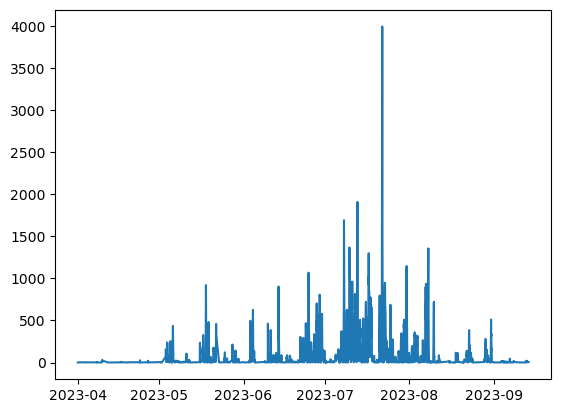

In [294]:
plt.plot(myfr[myfr.prov_name_en == 'British Columbia'].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == 'British Columbia'].InterCloud)
plt.plot()

/tmp/ipykernel_608/869230054.py:1: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  fire_stats.t = fire_stats.t.astype("datetime64[ns]").dt.tz_localize("UTC")


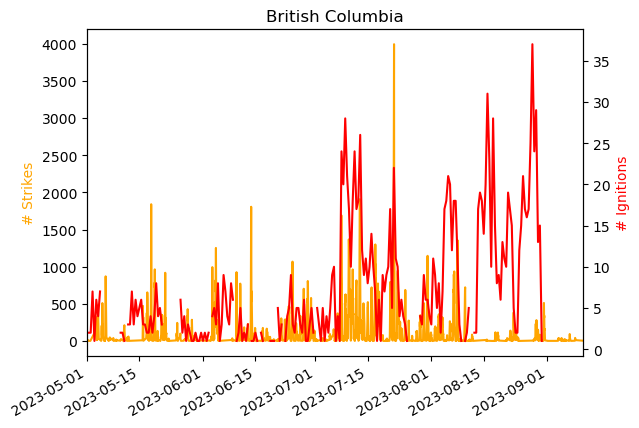

In [33]:
fire_stats.t = fire_stats.t.astype("datetime64[ns]").dt.tz_localize("UTC")

place = 'British Columbia'

fig, ax = plt.subplots()

ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
        color = "orange",
        label= "Lightning")
ax.set_ylabel("# Strikes", color = "orange")
ax.set_title(place)
#ax.legend()
ax2 = ax.twinx()
ax2.set_xlim(min(date_range), max(date_range))
ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place].igs), color = "red", label = "Ignitions")
#ax2.legend()
ax2.set_ylabel("# Ignitions", color = "red")
ax2.set_xlim(min(date_range), max(date_range))
fig.autofmt_xdate()

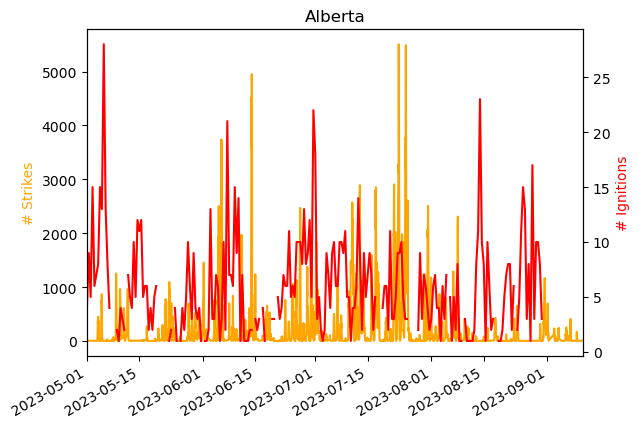

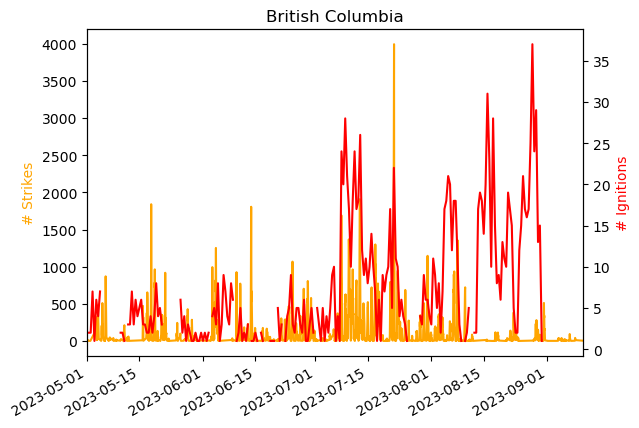

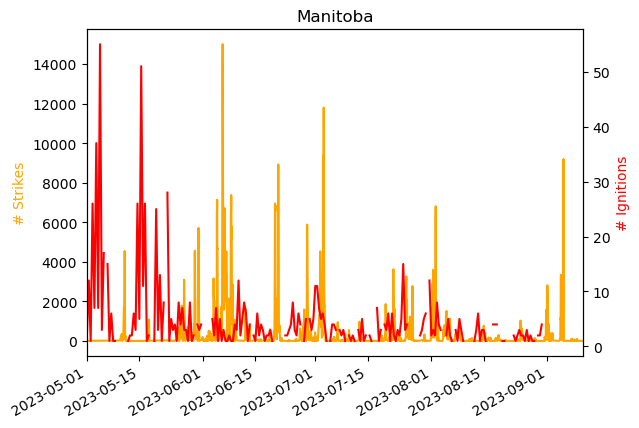

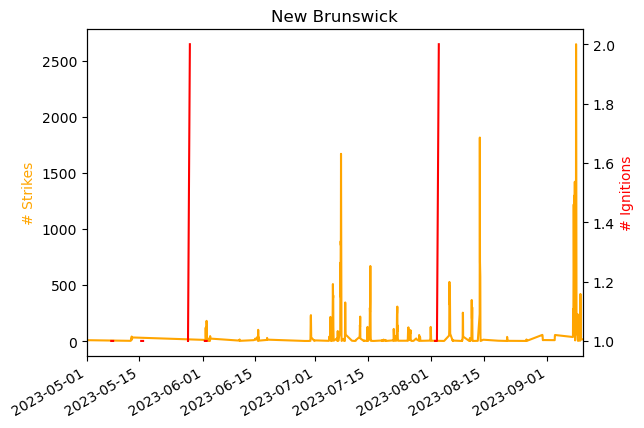

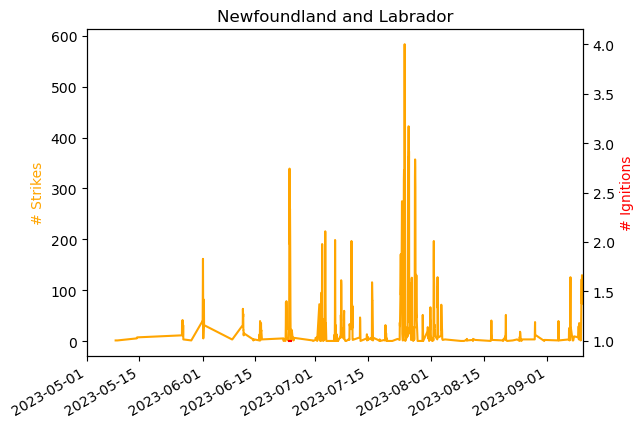

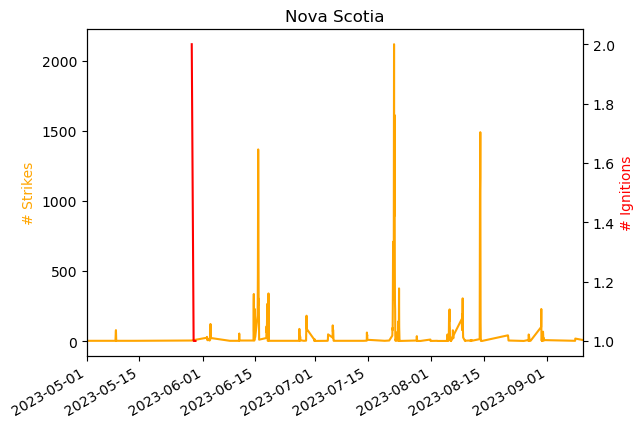

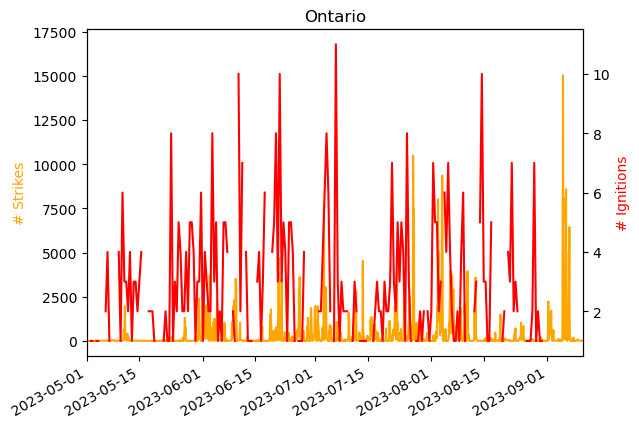

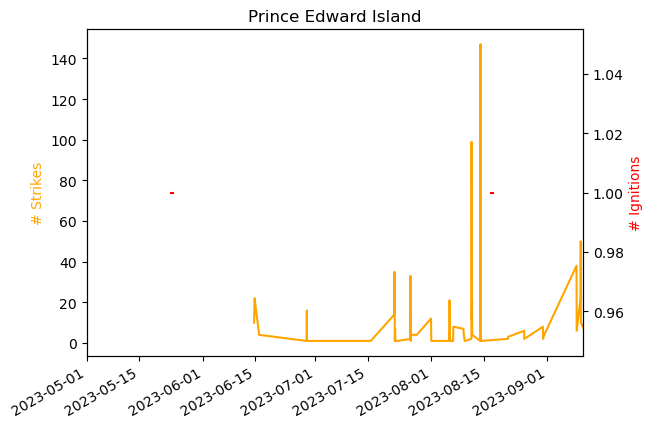

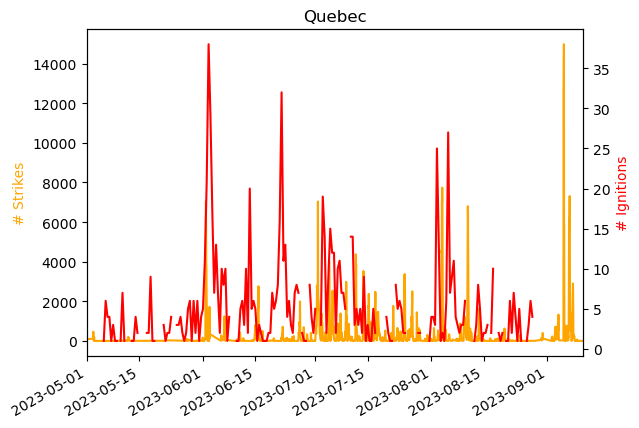

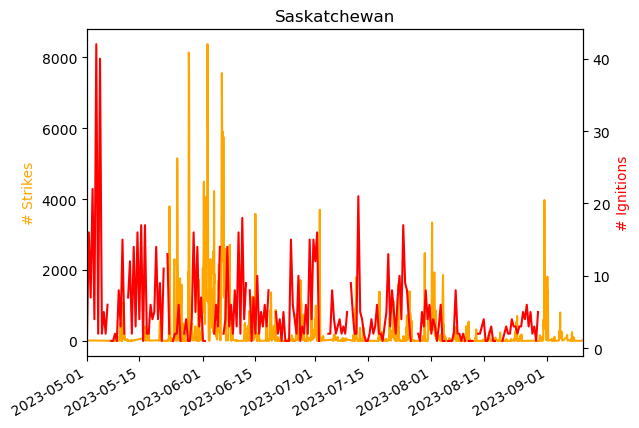

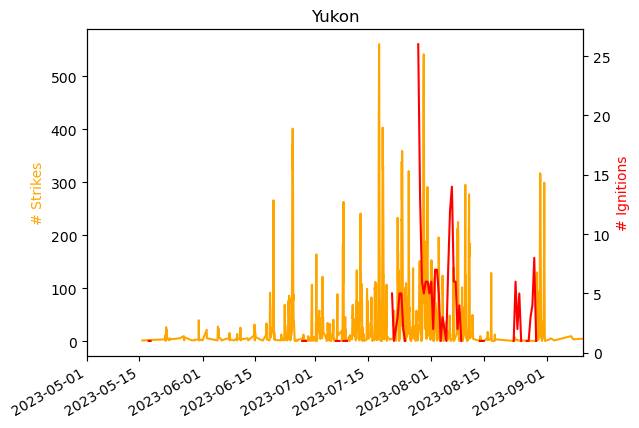

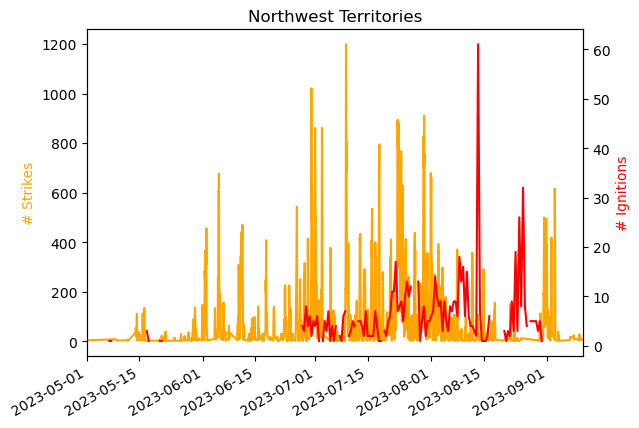

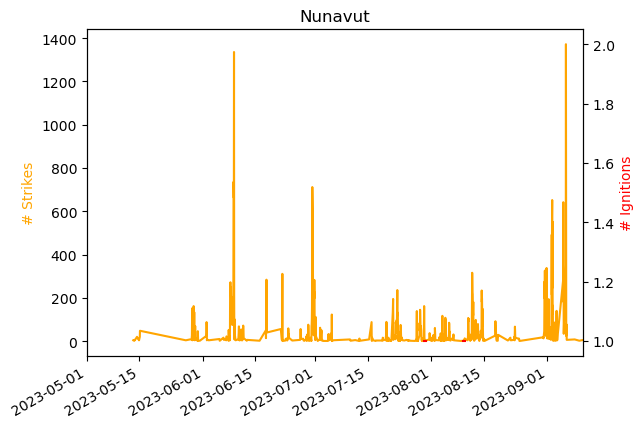

In [36]:
places = fire_stats.prov_name_en.unique()

for place in places:
    #if(max(fire_stats[fire_stats.prov_name_en == place].igs) <= 50):
    #    continue
    fig, ax = plt.subplots()
    ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
            color = "orange",
            label= "Lightning")
    ax.set_ylabel("# Strikes", color = "orange")
    ax.set_title(place)
    #ax.legend(loc = 0)
    ax2 = ax.twinx()
    ax2.set_xlim(min(date_range), max(date_range))
    ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place].igs), color = "red", label = "Ignitions")
    #ax2.legend()
    ax2.set_ylabel("# Ignitions", color = "red")
    ax2.set_xlim(min(date_range), max(date_range))
    fig.autofmt_xdate()
    

In [26]:
fire_stats.columns

Index(['prov_name_en', 't', 'farea', 'numfires', 'num_active_fires', 'tot_frp',
       'mean_frp', 'igs', 'num_active_pixels', 'fireID'],
      dtype='object')

/tmp/ipykernel_608/3578782742.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


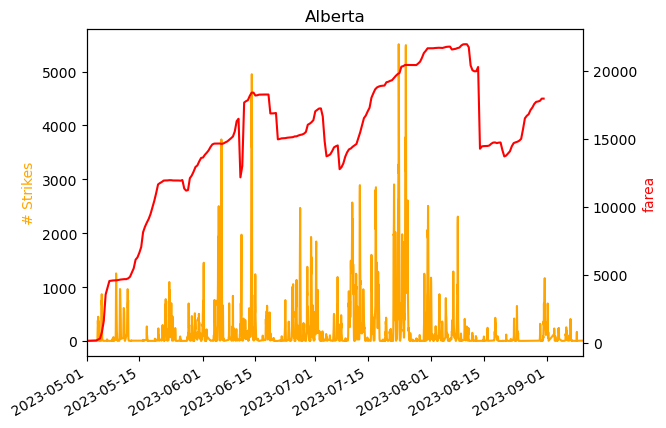

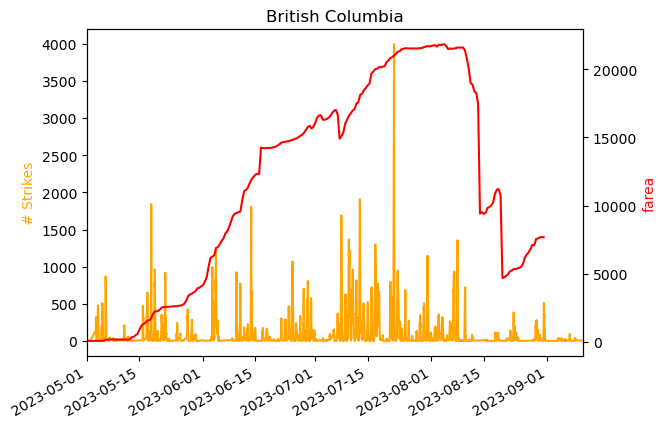

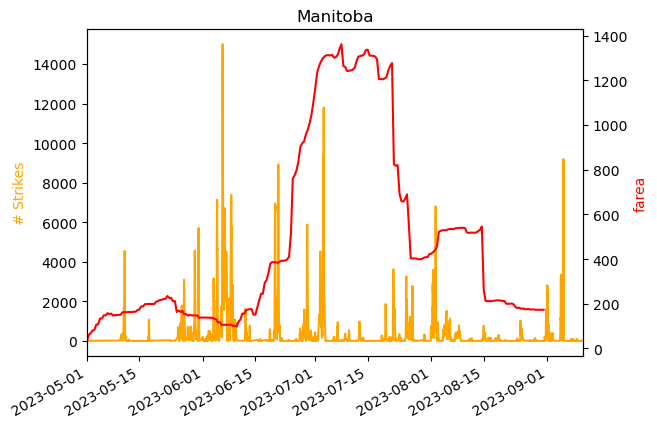

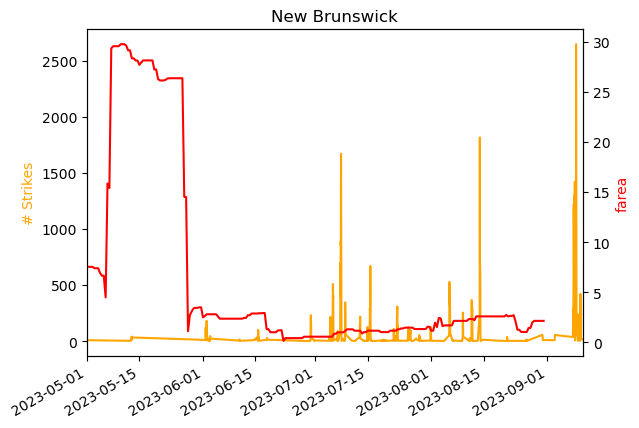

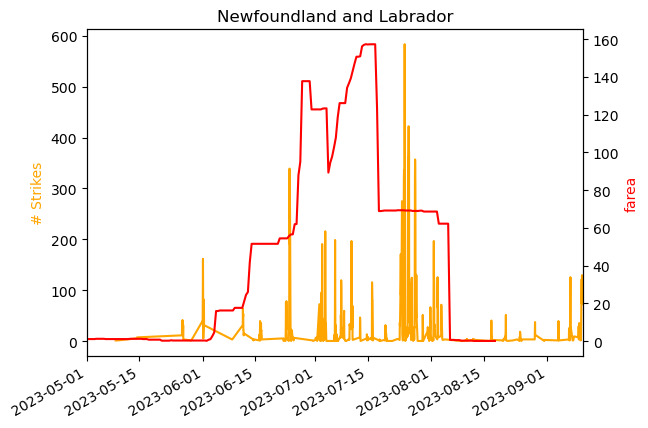

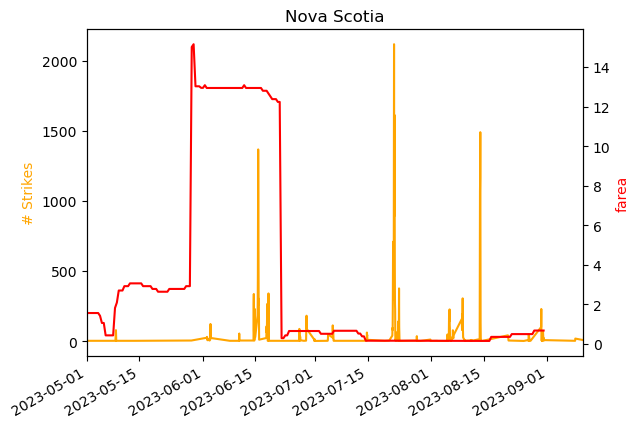

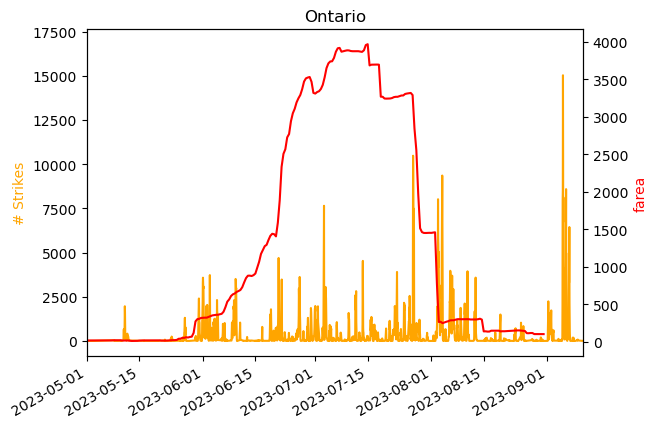

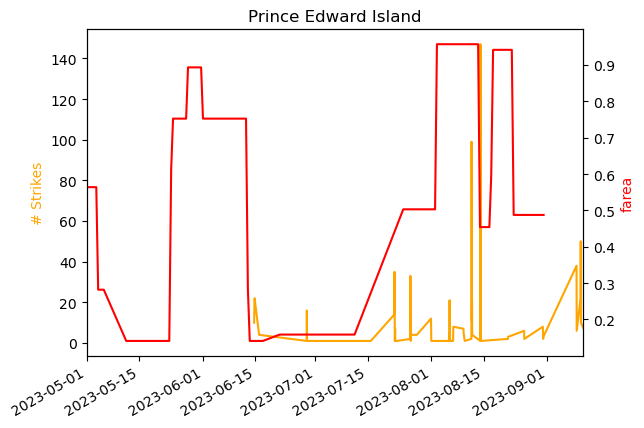

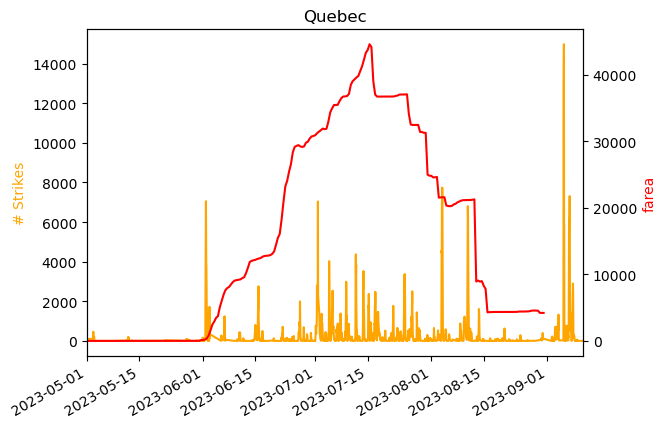

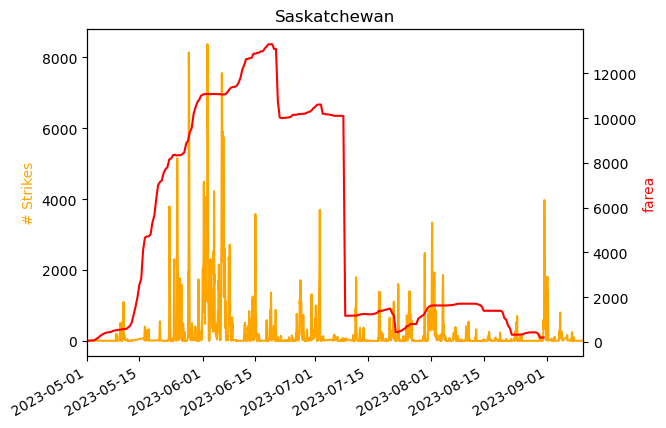

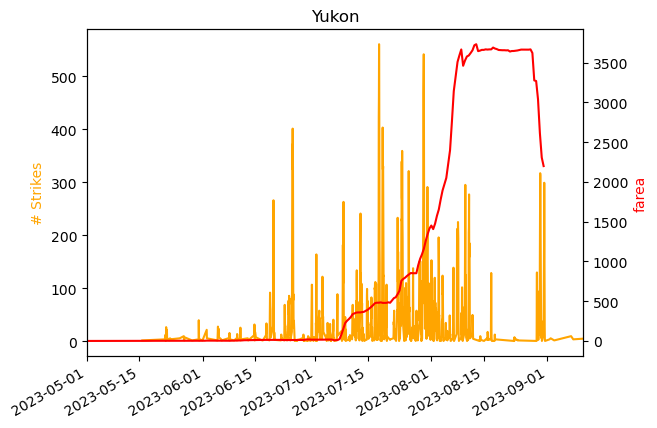

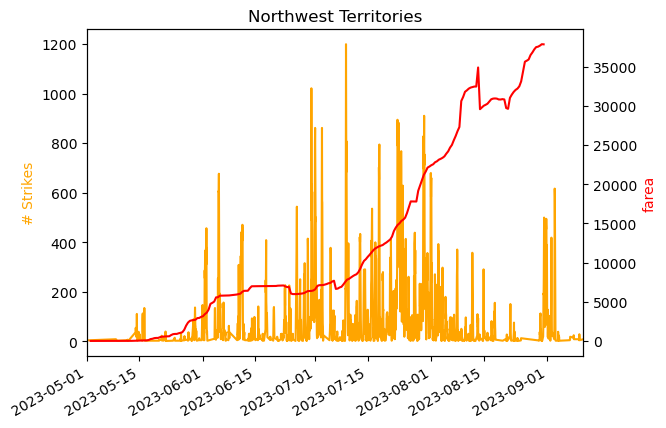

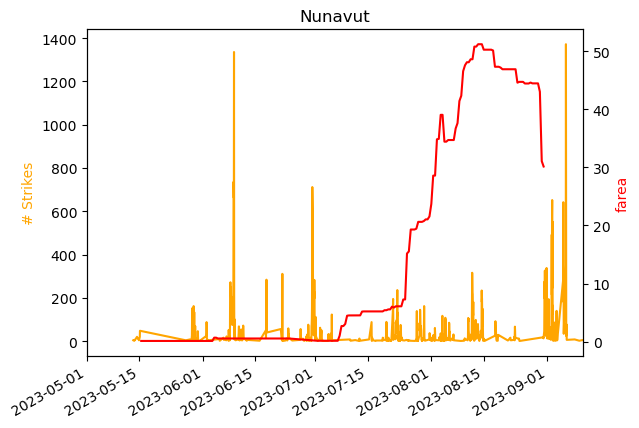

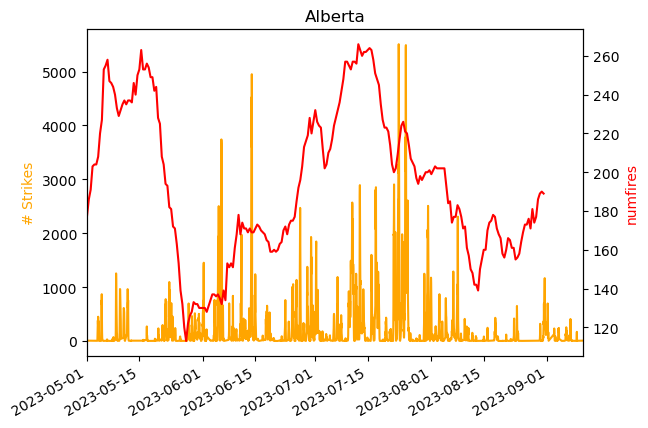

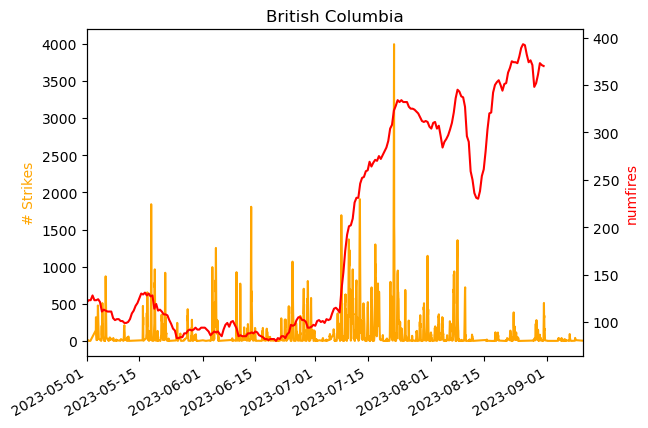

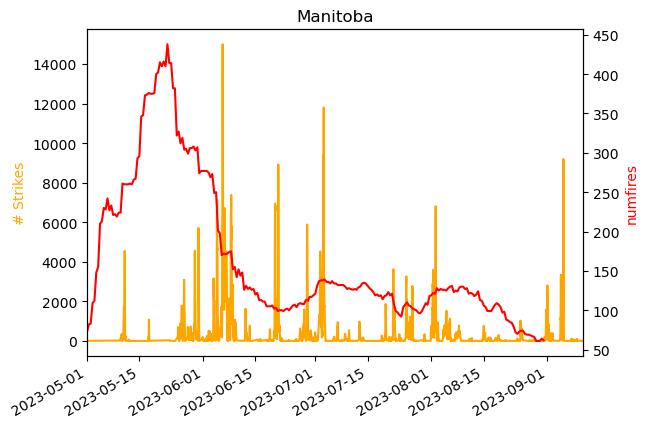

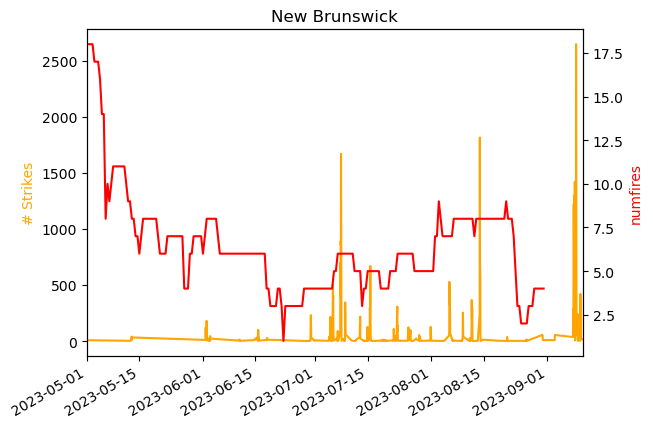

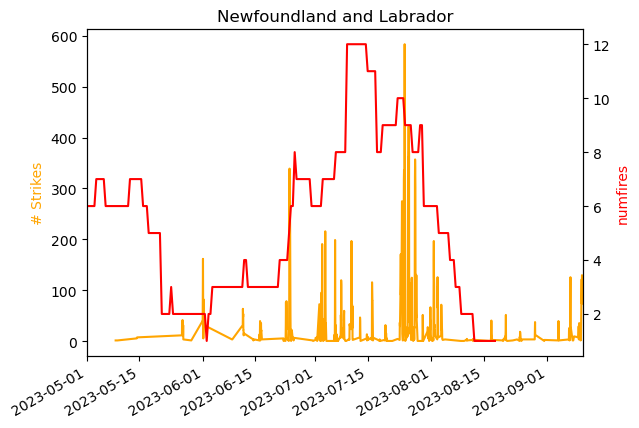

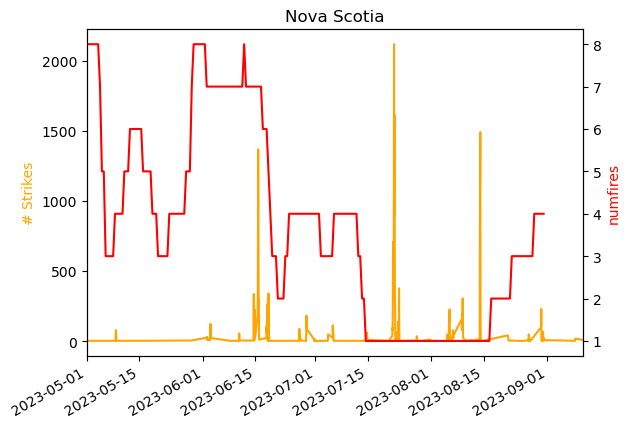

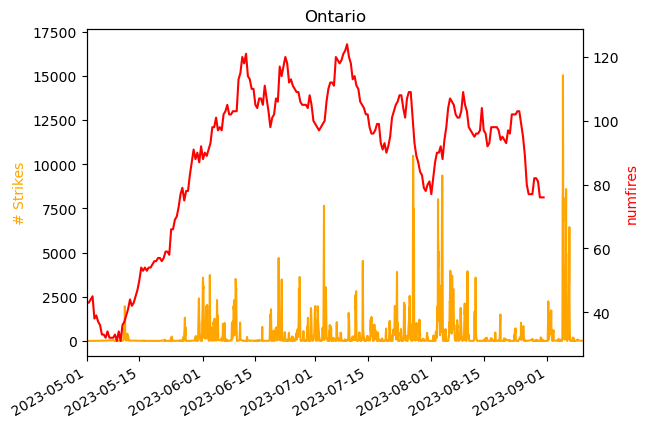

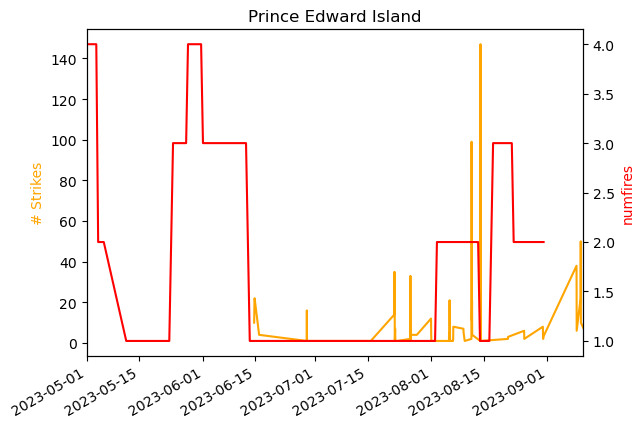

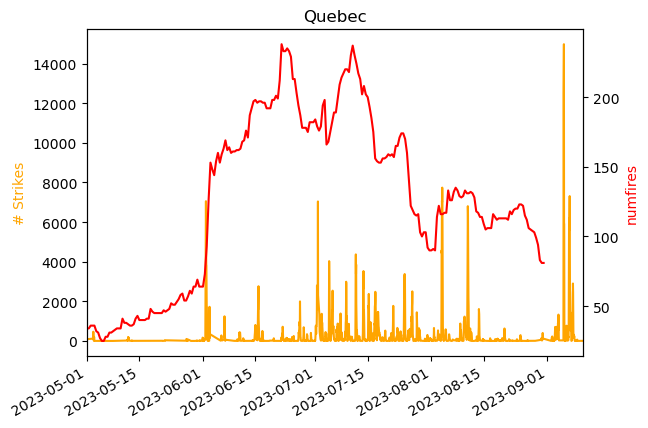

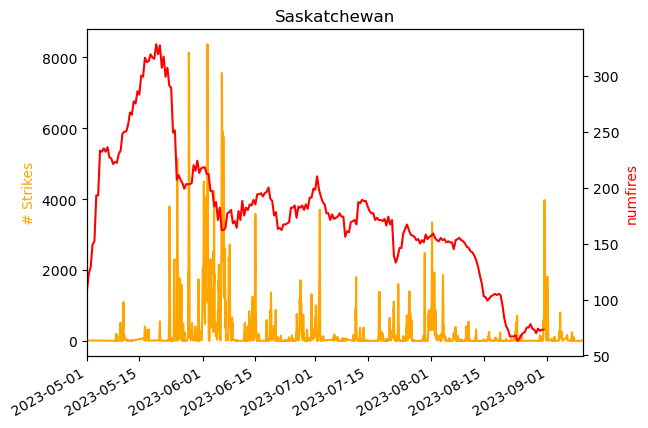

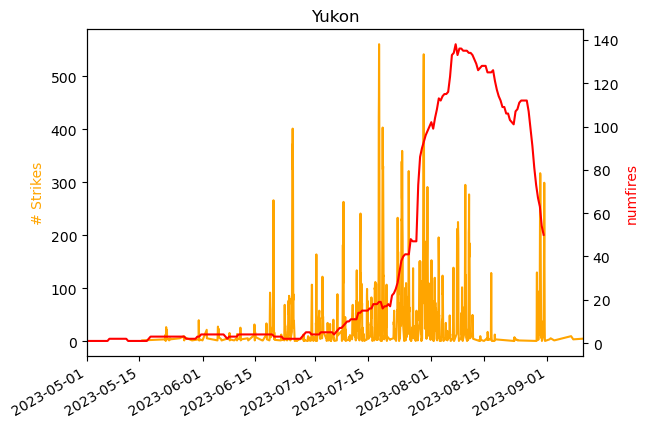

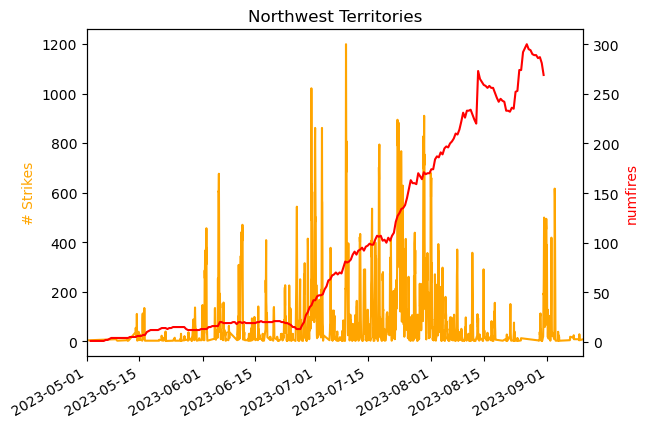

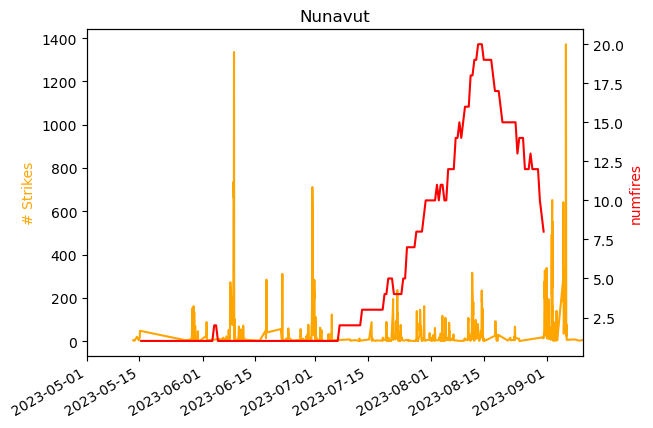

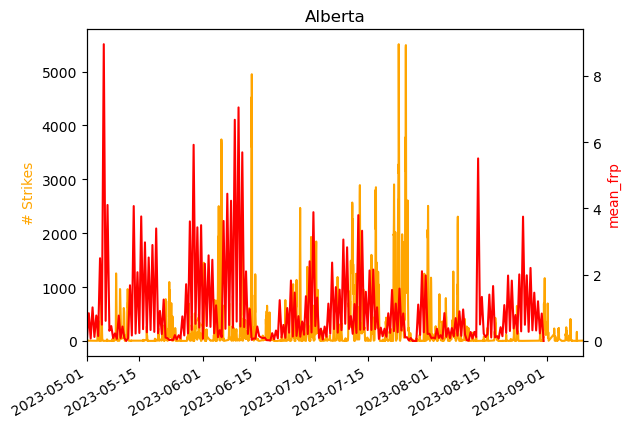

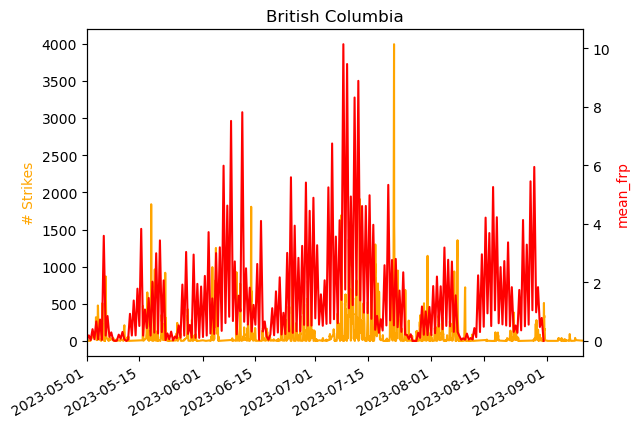

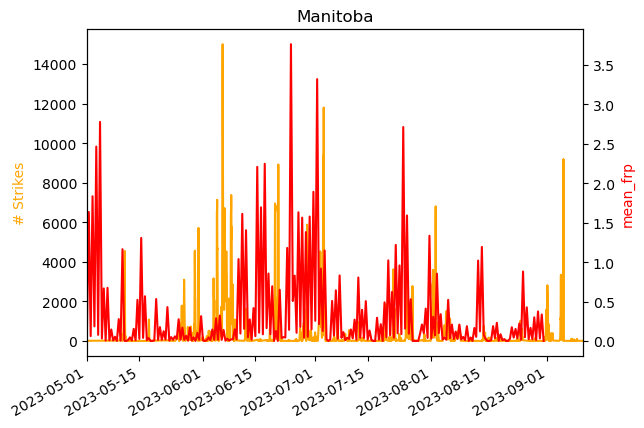

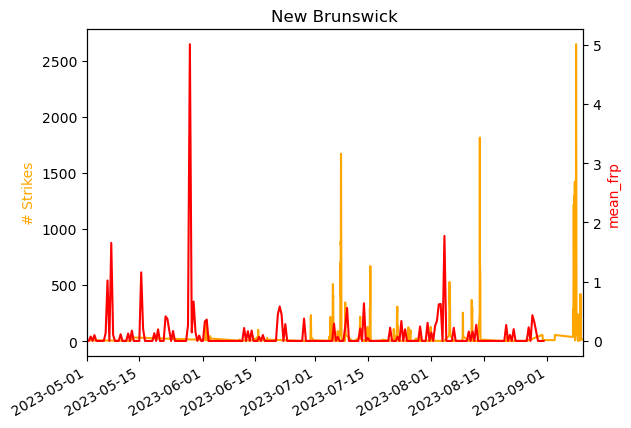

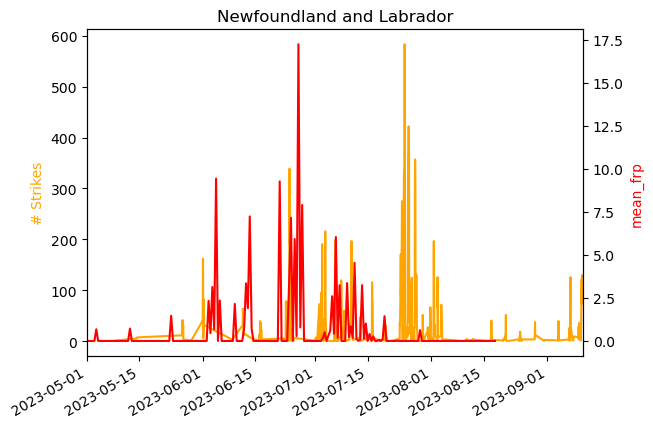

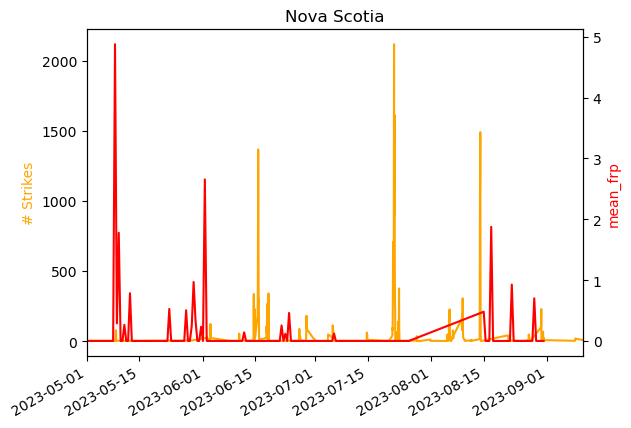

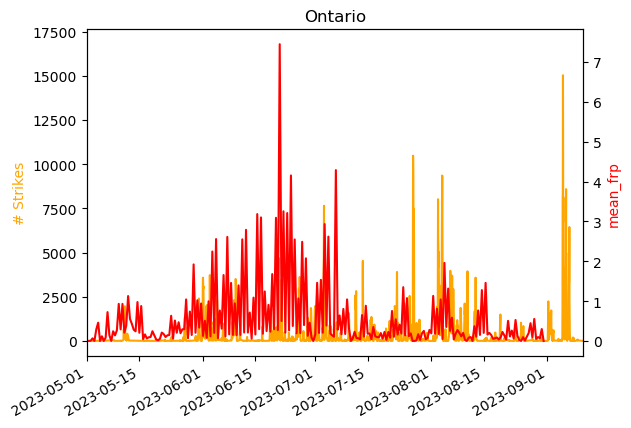

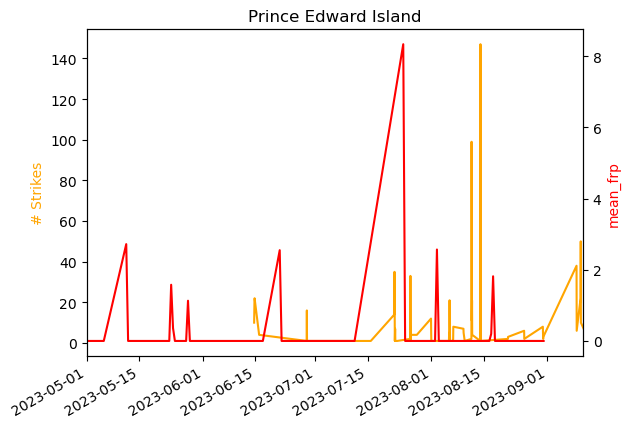

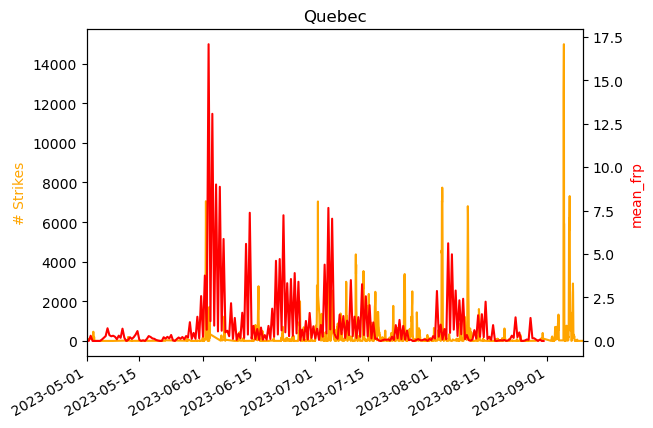

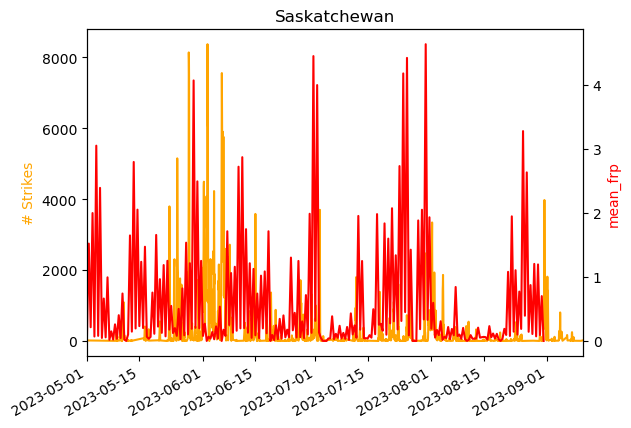

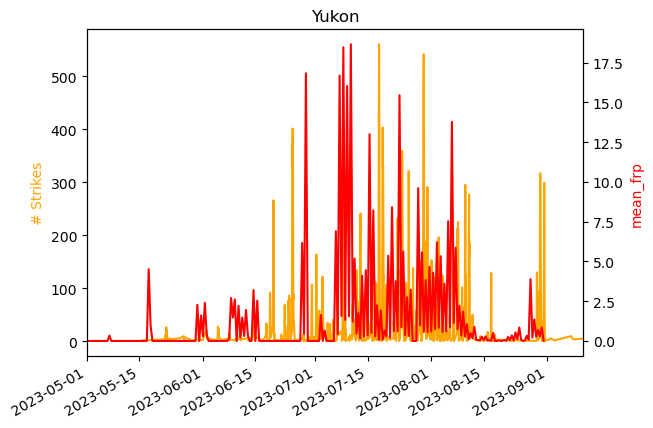

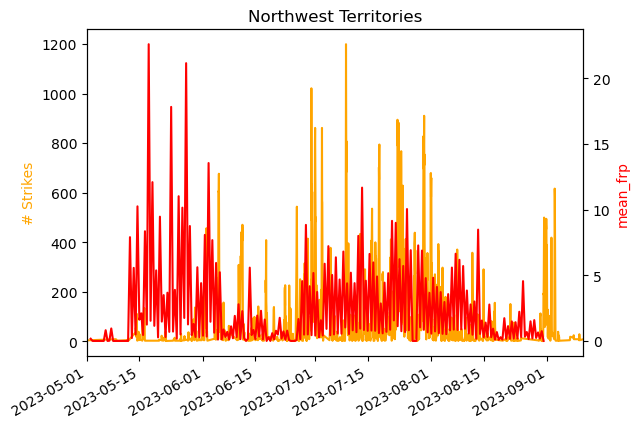

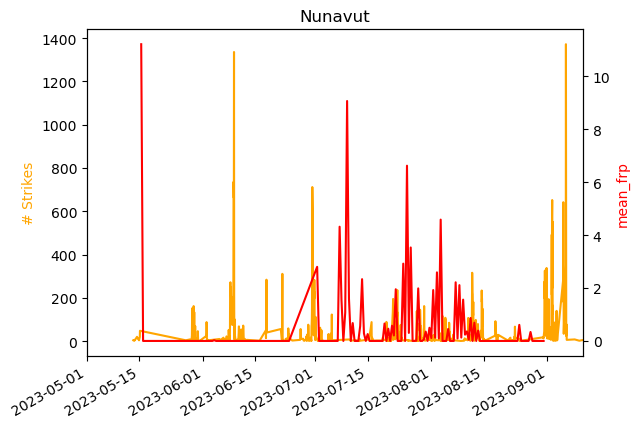

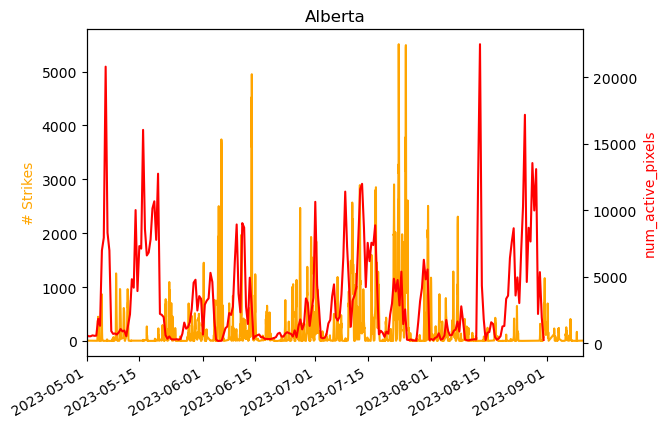

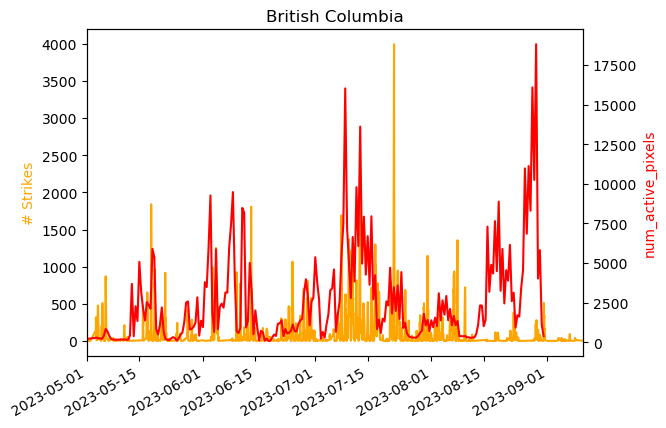

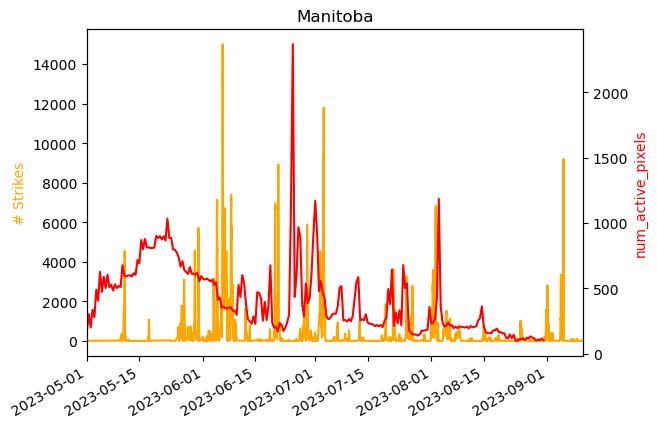

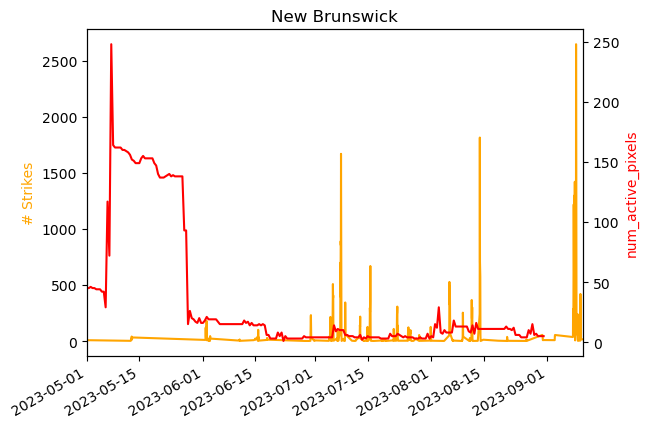

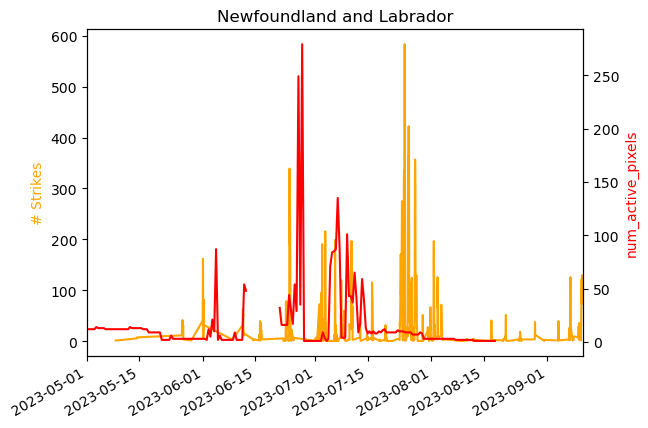

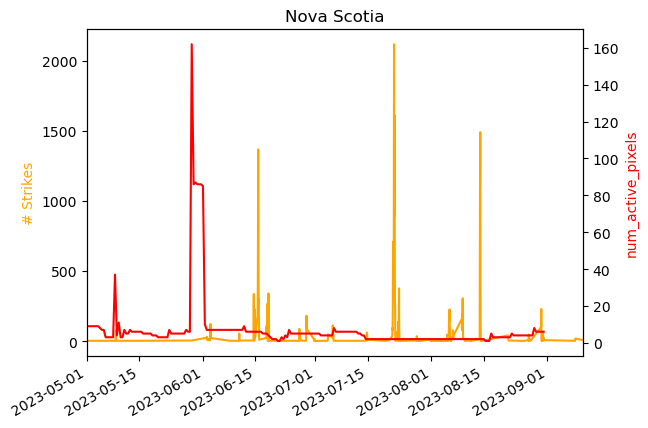

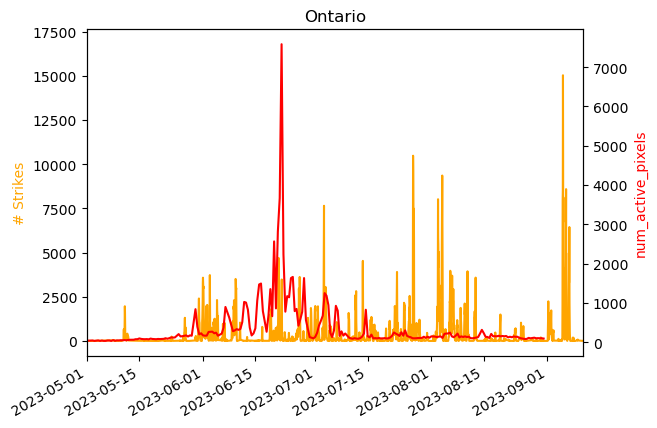

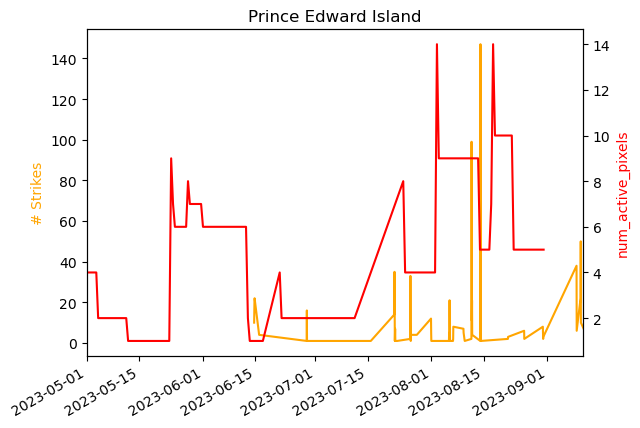

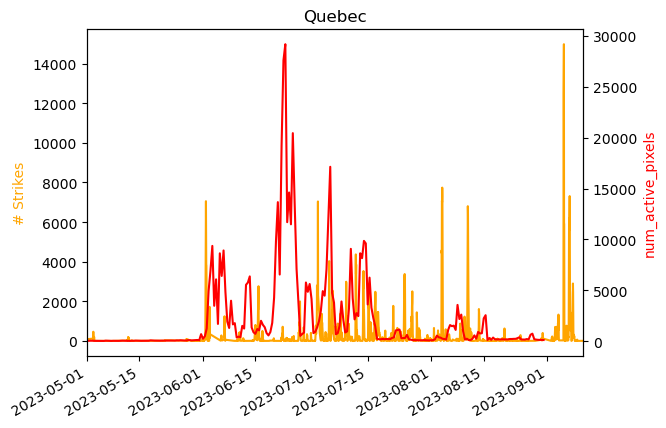

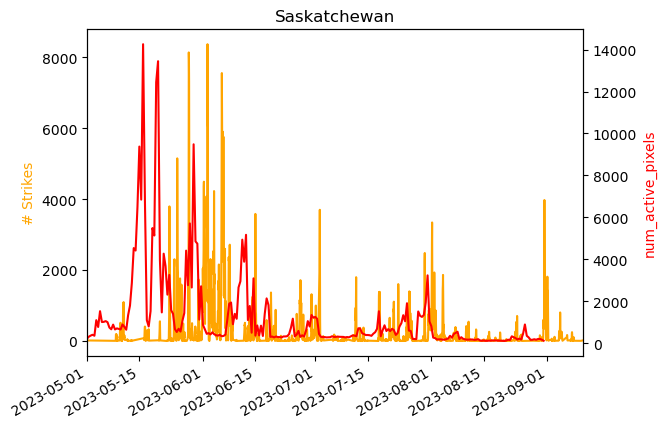

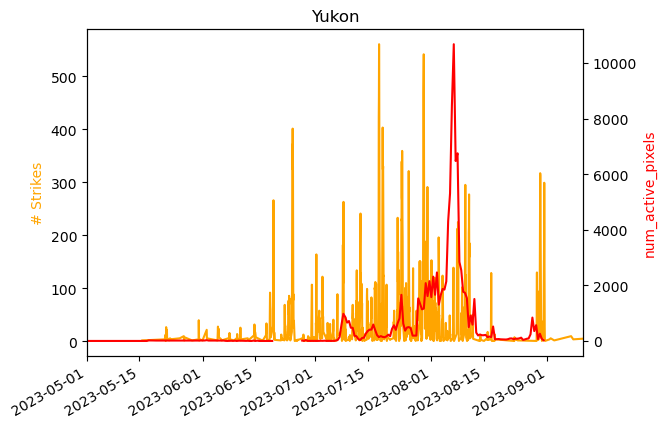

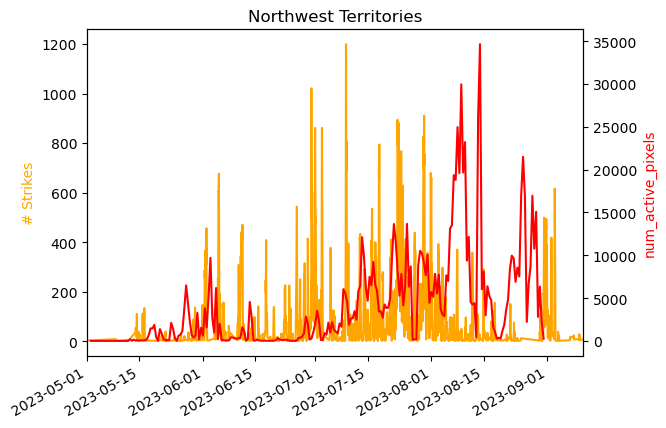

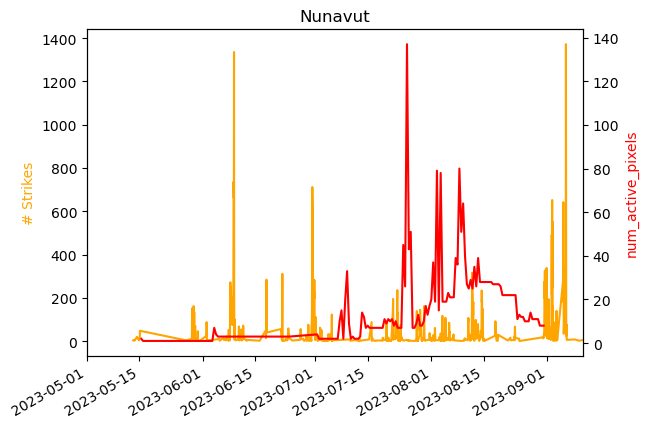

In [37]:
variables = ['farea', 'numfires', 'mean_frp', 'num_active_pixels']

for v in variables:
    for place in places:
        #if(max(fire_stats[fire_stats.prov_name_en == place].igs) <= 50):
        #    continue
        fig, ax = plt.subplots()
        ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
                color = "orange",
                label= "Lightning")
        ax.set_ylabel("# Strikes", color = "orange")
        ax.set_title(place)
        #ax.legend(loc = 0)
        ax2 = ax.twinx()
        ax2.set_xlim(min(date_range), max(date_range))
        ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place][v]), color = "red", label = v)
        #ax2.legend()
        ax2.set_ylabel(v, color = "red")
        ax2.set_xlim(min(date_range), max(date_range))
        fig.autofmt_xdate()